In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [34]:

from IPython.display import display, Latex
#import sympy
from sympy import symbols, series, Function, fourier_series, lambdify, Order
from sympy import sin, exp, atan, pi
from sympy import expand, collect, apart, simplify
from sympy import solve, solveset, nonlinsolve, dsolve
from sympy.interactive import printing
from sympy import latex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter
from scipy import stats
from scipy.optimize import root_scalar
from math import log10
import os
from converter6 import myprint, myprint2
from PyLTSpice import LTSpice_RawRead
from PyLTSpice.LTSteps import LTSpiceLogReader
printing.init_printing(use_latex=True)

In [2]:
R = symbols('R', real=True, positive=True)
C = symbols('C', real=True, positive=True)
Zc = symbols('Z_C', real=True, positive=True)
t = symbols('t', real=True, positive=True)
Vo = Function('V_o', real=True)
phi = symbols('phi', real=True)
theta = symbols('theta', real=True)
ipk= symbols('i_pk', real=True, positive=True)
iD = symbols('i_D', real=True, positive=True)
iin = symbols('i_{in}', real=True, positive=True)
w=symbols('omega', real=True, positive=True)
freq=85e3


### Idea 1. 
#### For a non-resonant driven rectifier, use a polynomial approximation of exponential and sinusoid around the intersection. Subtract and find the root.  If quadratic approximations are good, this could offer a closed form analytic solution.  The time t of the intersection is scaled by tau: t= tau * root, because phi=t/tau=root. A fast tau means the exponential falls quicker to meet the rising sinusoid.  The starting point for the exponential is not 1 at phi=0: it is the value at pi/4, and we assume tau >> T. 

### Idea 2. 
#### Numerically solve for the root of the transcendental equation. 

### Idea 3. 
#### Use fourier approximation and super position. 3a) and solve the linear differential equations. 3b) multiply the fourier components by the output impedence. The output R and C form a current divider. The ripple can be computed by the current through the resistor.  

### Idea 1

In [ ]:
def get_rid_of_O(expr):
    mask = [type(arg) is Order for arg in expr.args]
    idx_of_O = mask.index(True)
    removed_O=expr.args[:idx_of_O]+expr.args[idx_of_O+1:]
    return expr.func(*removed_O)

In [ ]:
sin_approx = get_rid_of_O(series(sin(phi), phi, pi/4, n=3))
exp_approx = get_rid_of_O(series(exp(-phi), phi, pi/4, n=3))

In [ ]:

myprint(exp(-phi),collect(expand(exp_approx), phi) , exact=False)
myprint(sin(phi),collect(expand(sin_approx), phi), exact=False )
myprint(exp(-phi),collect(expand(exp_approx.evalf(2)), phi) , exact=False)
myprint(sin(phi),collect(expand(sin_approx.evalf(2)), phi) , exact=False)

In [ ]:
f = exp_approx - sin_approx
simplify(collect(expand(f), phi))

In [ ]:
myprint(exp(-phi) - sin(phi), collect(expand((exp_approx - sin_approx).evalf(2)), phi) , exact=False)
solve((exp_approx - sin_approx).evalf(2), phi)
#solveset((exp_approx - sin_approx), phi)

In [ ]:
sin_approx = lambdify(phi, sin_approx)
exp_approx = lambdify(phi, exp_approx)

In [ ]:
angles = np.linspace(-np.pi, np.pi, 100)
ans = sin_approx(angles)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(angles, sin_approx(angles), marker='*', markevery=10, label='poly approx to sin(\u03D5)')
ax1.plot(angles, np.sin(angles), marker='v', markevery=9,label='sin(\u03D5)')
ax1.set_xlim(-1,)
ax1.set_xlabel('Angle [rad]')
ax1.set_ylim(-1.2, 1.2)
ax1.set_title('Comparison of sin(\u03D5) to its approximation')
ax1.legend()

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(angles, exp_approx(angles), marker='*', markevery=10, label='poly approx to exp(-\u03D5)')
ax1.plot(angles, np.exp(-angles), marker='v', markevery=9,label='exp(-\u03D5)')
ax1.set_xlim(-.5,)
ax1.set_xlabel('Angle [rad]')
ax1.set_ylim(-.2, 1)
ax1.set_title('Comparison of exp(-\u03D5) to its approximation')
ax1.legend()

### Solve for the root numerically 

In [ ]:
#This uses the approximations, although the exact functions would probably work too. 

t = np.linspace(-.1/freq, .5/freq, 100)
t2 = np.linspace(0, .5/freq, 100)
tau = 3/freq
w = 2*np.pi*freq
Vpk = 1
k = np.exp(-.25/(freq*tau))
def sin_approx(phi):
    return Vpk*(phi - phi**3/6 + phi**5/120- phi**7/5040)
sin_approx_v = np.vectorize(sin_approx)
def g(t):
    #k = Vpk*np.exp(-.25/(freq*tau))
    return  k*np.exp(-t/tau)
def f(t):
    return sin_approx(w*t) - k*np.exp(-t/tau)
def h(t):
    return np.sin(w*t) - k*np.exp(-t/tau)
    
gv = np.vectorize(g)
plt.plot(t[::4], Vpk*np.sin(w*t[::4]), marker='*', label='sin(\u03C9*t)')
plt.plot(t[::5], sin_approx_v( w*t[::5]), marker='x', label = 'poly approx to sin(\u03D5)')
plt.plot(t, np.sin(w*t) - k*np.exp(-t/tau), label=r'$e^{-t/RC} - sin(\phi)$')
#plt.plot(t2, gv(t2), label='exponential' )
#plt.plot(t2[::5], gv(t2[::5]), linestyle='None', marker='o')
plt.plot(t2[::5], gv(t2[::5]), marker='o', label=r'exponential: $e^{-t/RC}$ ' )
plt.ylim(-1, 1.1)
plt.xlim(0, 3e-6)
plt.title(r'Finding root of $e^{-t/RC} - sin(\omega t) = 0$ ')
plt.legend()

res = root_scalar(h, bracket=[1e-6, 3e-6])
t3  = res.root

In [ ]:
t3

In [ ]:
def cp_angle(theta):
    theta_rad = theta*np.pi/180
    imag = np.sin(theta_rad)
    real = np.cos(theta_rad)
    return np.complex(real, imag)

#### Fourier breakdown 

In [ ]:
rectifiedwave =ipk*abs(sin(theta))
four_rectifiedwave = fourier_series(rectifiedwave, (theta, -pi, pi))
four_rectifiedwave = four_rectifiedwave.truncate(4)
four_rectifiedwave = four_rectifiedwave.subs(theta,w*t)
four_rectifiedwave

(1) Time Domain - solve a first order diff eq

$V_{out} = i_R \cdot R = (i_{in}-i_C)\cdot R = (i_{in} - C\cdot \frac{dV_{out}}{dt}) \cdot R = i_{in}\cdot R - RC\cdot \frac{dV_{out}}{dt}$



In [ ]:
result = "$${} = {} \\approx {} $$".format(latex(iin), latex(rectifiedwave), latex(four_rectifiedwave))
result

display(Latex(result))

In [ ]:
sdc = four_rectifiedwave.args[0]
s1 = four_rectifiedwave.args[1]
s2 = four_rectifiedwave.args[2]
s3 = four_rectifiedwave.args[3]
result = "$${}$$".format(latex(sdc))
print('DC component')
display(Latex(result))
result = "$${}$$".format(latex(s1))
print('fundamental')
display(Latex(result))
result = "$${}$$".format(latex(s2))
print('2nd harmonic')
display(Latex(result))
result = "$${}$$".format(latex(s3))
print('4th harmonic')
display(Latex(result))

In [ ]:

eqdc =Vo(t) - sdc*R + R*C*Vo(t).diff(t)
eq1 = Vo(t) - s1*R + R*C*Vo(t).diff(t)
eq2 = Vo(t) - s2*R + R*C*Vo(t).diff(t)
eq3 = Vo(t) - s3*R + R*C*Vo(t).diff(t)
eqdc
eq1
eq2
eq3

In [ ]:
soldc = dsolve(eqdc, func=Vo(t),  ics={Vo(0):0}, hint='nth_linear_constant_coeff_undetermined_coefficients')
sol1 = dsolve(eq1, func=Vo(t),  ics={Vo(0):0}, hint='nth_linear_constant_coeff_undetermined_coefficients')
sol2 = dsolve(eq2, func=Vo(t),  ics={Vo(0):0}, hint='nth_linear_constant_coeff_undetermined_coefficients')
sol3 = dsolve(eq3, func=Vo(t),  ics={Vo(0):0}, hint='nth_linear_constant_coeff_undetermined_coefficients')
#sol = simplify(sol)
#sol
vodc = soldc.rhs
vo1 = sol1.rhs
vo2 = sol2.rhs
vo3 = sol3.rhs
#vo = lambdify(t, vo.subs(vals))
vodc
vo1
vo2
vo3


ipk is NOT 15, that's the INPUT VOLTAGE PEAK 
we do know the required load current is 400A, and how to relate diode current to output DC current. 
i_avg = 2/pi * i_pk
This is useful for a current source input. 
But, with a voltage source, still need to know what V gives that I. 
The real power is dissipated in the damping resistance and the load resistance. 
Vout = Iout*R = Iin*2/pi 
Pout = Vout*Iout 
Pin = Vin*Iin = Vout*Iout + losses 
Vin = Vo*Ii

There is actually no real scenario where the tank is driven by a sinusoidal voltage. 
In the test, it's driven by square wave inverter, which has fourier terms that ARE sinusoidal. 

If the max time step is small enough, 
and without an output cap, the average Vout 
is the average of a rectified (voltage) sinusoid: 2/pi=.63 That voltage is determined by ___ 
Without any load (inf R), the rectified 
output average is precisely Vinpk, but only if the tank is ideal. If there is Rdamping, 

For a given Rload, does Cload only effect ripple, or also the average? 

In [ ]:
vals = {ipk:400*np.pi/2, R: 48/400, C: 250e-6, w:freq*2*pi, theta:((2*pi*freq)*t).evalf(3)}
print(f'R/Zc = {vals[R]/(1/(freq*2*np.pi*vals[C]))}')

In [ ]:
fvodc = lambdify(t, expand(vodc).subs(vals)) #the expand is found necessary for convergence to break up the exponential terms
fvo1 = lambdify(t, expand(vo1).subs(vals)) #the expand is found necessary for convergence to break up the exponential terms
fvo2 = lambdify(t, expand(vo2).subs(vals)) #the expand is found necessary for convergence to break up the exponential terms
fvo3 = lambdify(t, expand(vo3).subs(vals)) #the expand is found necessary for convergence to break up the exponential terms

In [ ]:
periods = 1.3
t_1 = np.linspace(0, periods/freq, 200)
myfunc = lambdify(t, four_rectifiedwave.subs(vals))
myfunc2 = lambdify(t, rectifiedwave.subs(vals))
fig, ax1 = plt.subplots()
ax1.plot(t_1, myfunc(t_1),  linestyle='-', marker='o', markevery=9, label ='4 fourier terms of |sin(x)| ')
theta_ = np.linspace(0, periods*2*np.pi, 200)
ax1.plot(t_1 ,myfunc2(t_1), linestyle='-', marker='*', markevery=8,label='|sin(x)|')
major_formatter= EngFormatter(unit='s', places=1, sep='')
ax1.xaxis.set_major_formatter(major_formatter) 
ax1.yaxis.set_major_formatter(EngFormatter(unit='A', places=1, sep='')) 
ax1.set_title('Fourier Approximation of 85kHz Rectified Sinusoid')
ax1.legend()

In [ ]:
periods/freq

In [ ]:
periods = 25
samples_per_period = 25
total_samples = periods*samples_per_period
t_ = np.linspace(0, periods/freq, total_samples)
total =  fvodc(t_) + fvo1(t_) + fvo2(t_) + fvo3(t_)


#### Plot the initial output transient for the particular R and C. 
Plot with values that show a large ripple, and values that show flat. 
Try to get them with the same average. 

A voltage source and a resonant tank does put in abs(sin) current waveform shape. 
Without a tank, it's the VOLTAGE that looks like abs(sin), which has a DC content of 2*Vpk/pi. 

The plot below is the solution of the ODEs that describe the abs(sin) waveform driving the output RC. 
It can be compared to a spice simulation. 


In [ ]:
%matplotlib inline
path_to_raw = 'C:\\Users\\eriki\\Documents\\LTspiceXVII\\Twenty_kW\\'
raw = os.path.join(path_to_raw+'Rectifier_Test8.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
Vout = LTR.get_trace("V(vout)").get_wave()
#iin = LTR.get_trace("I(D2)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()
fig, ax1 = plt.subplots()
ax1.plot(t_,  total , linestyle='None',marker='*', markevery=8,  label='Solution to ODEs')
ax1.plot(t_sim, Vout, label='Spice')
major_formatter= EngFormatter(unit='s', places=1, sep='')
ax1.xaxis.set_major_formatter(major_formatter)    
ax1.set_title('Solution to first 4 fourier O.D.Es, 400A output current')
ax1.set_ylabel('Output Voltage [V]')
ax1.set_xlabel('Time')
ax1.legend()
ax1.annotate(r'$\frac{R_{load}}{Z_{Cload}} =$' + f'{vals[R]/(1/(freq*2*np.pi*vals[C])):.2f}', (.5,.5), xycoords='axes fraction', fontsize='xx-large')

#### The above shows the well understood rectifier current-to-output voltage conversion. 
#### The input current is closely proportioned to input voltage, as seen below and in test_4_.asc 
#### The highly nonlinear and hard-to-predict is the effect of varying load 
any given load -> don't know voltage -> can't know current -> 
The phase shift from abs(I(L1)) to Vout is the net result of all the fourier components phase shifts, and its just 90 because the output is mostly capacitive. 


#### Show spice results with varying load, but cap is always large enough to take all the AC current. 

In [3]:

path_to_raw = 'C:\\Users\\eriki\\Documents\\LTspiceXVII\\Twenty_kW\\'
#raw = os.path.join(path_to_raw+'Rectifier_Test5-10to100m,Vin200.log')
raw = os.path.join(path_to_raw+'Rectifier_Test5_largesweep.log')
data = LTSpiceLogReader(raw,step_set ={})

#raw2 = os.path.join(path_to_raw+'Rectifier_Test5-1Megto10,Vin200.log')
#data2 = LTSpiceLogReader(raw2,step_set ={})
print("Number of steps  :", data.step_count)
step_names = data.get_step_vars()
meas_names = data.get_measure_names()

# Printing Headers
print(' '.join([f"{step:10s}" for step in step_names]), end='')  # Print steps names with no new line
print(' '.join([f"{name:10s}" for name in meas_names]), end='\n')
# Printing data
for i in range(data.step_count):
    print(' '.join([f"{data[step][i]:10}" for step in step_names]), end='')  # Print steps names with no new line
    print(' '.join([f"{data[name][i]:10}" for name in meas_names]), end='\n')  # Print Header

print("Total number of measures found :", data.measure_count)


Number of steps  : 15
rload     voavg      voavg_FROM voavg_TO   gain      
       0.1   34.1158 0.00458824 0.00470588   0.170579
  0.316228   55.3818 0.00458824 0.00470588   0.276909
         1    68.786 0.00458824 0.00470588    0.34393
   3.16228   74.7837 0.00458824 0.00470588   0.373918
        10   79.5272 0.00458824 0.00470588   0.397636
   31.6228   85.5801 0.00458824 0.00470588   0.427901
       100   90.8727 0.00458824 0.00470588   0.454363
   316.228    94.694 0.00458824 0.00470588    0.47347
      1000   97.1763 0.00458824 0.00470588   0.485881
   3162.28   98.6651 0.00458824 0.00470588   0.493325
     10000   99.4838 0.00458824 0.00470588   0.497419
   31622.8   99.8039 0.00458824 0.00470588   0.499019
    100000   99.5802 0.00458824 0.00470588   0.497901
    316228   98.7023 0.00458824 0.00470588   0.493511
 1000000.0   98.6769 0.00458824 0.00470588   0.493384
Total number of measures found : 30


Text(0.5, 1.0, 'Spice results of varying load resistance, keeping $Z_c$=.01*$R_L$')

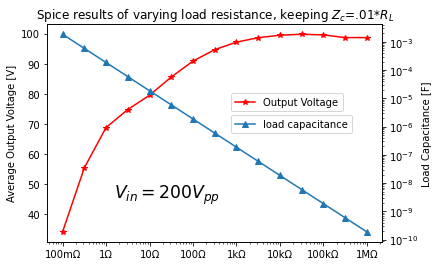

In [4]:

rload = data['rload']
voavg = data['voavg']
cload = 1/(2*np.pi*freq*.01*np.array(rload))
fix, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(rload, voavg ,marker='*', label='Output Voltage', color='red')
major_formatter= EngFormatter(unit='\u03A9', places=0, sep='')
ax.xaxis.set_major_formatter(major_formatter)    
ax2 = ax.twinx()
ax2.plot(rload ,cload, marker='^', label='load capacitance')
major_formatter= EngFormatter(unit='F', places=1, sep='')
ax2.yaxis.set_major_formatter(major_formatter)    
ax.legend(loc=(.55,.6))
ax2.legend(loc=(.55,.5))
ax2.set_yscale('log')
ax.set_ylabel('Average Output Voltage [V]')
ax2.set_ylabel('Load Capacitance [F]')
ax.annotate(r'$V_{in} = 200V_{pp}$', (.2,.2), xycoords='axes fraction', fontsize='xx-large')
ax.set_title(r'Spice results of varying load resistance, keeping $Z_c$=.01*$R_L$')
#ax.yaxis.set_major_formatter(EngFormatter(unit='03A9', places=1, sep=''))   

In [ ]:
from converter6 import *
Iin = variable('i_{in}', real=True, positive=True)
Io = variable('i_{o}', real=True, positive=True)
Rl = variable('R_L', real=True, positive=True)
Rd = variable('R_d', real=True, positive=True)
Vo =variable('V_o', real=True)
Vin = variable('V_{in}', real=True)

In [ ]:

c = converter()
c.equations.add(Vin*Iin - (Vo*Io + Iin**2*Rd)) #VLavg must equal 0 in steady state
c.equations.add(Iin - Io*pi/2)
c.equations.add(Vo/Rl - Io)
c.showequations()
myprint(Vo, *c.solver(given={}, want=Vo))

#### Comparison of FHA to actual behavior 

In [ ]:

model_Vout = (Vin*pi/2)/(1+(pi/2)**2*Rd/Rl)
f = lambdify(Rl, model_Vout.subs({Vin:100, Rd:.1}))

In [ ]:
#raw = os.path.join(path_to_raw+'Rectifier_Test5.log')
#data = LTSpiceLogReader(raw,step_set ={})
#rload = data['rload']
#voavg = data['voavg']
cload = 1/(2*np.pi*freq*.01*np.array(rload))
fix, ax = plt.subplots(1,1)
#ax.set_xscale('log')
ax.plot(rload, voavg ,marker='*', label='Output Voltage', color='red')
#ax.plot(np.linspace(1,50,10), f(np.linspace(1,50,10))-50  ,marker='*', label='model')
major_formatter= EngFormatter(unit='\u03A9', places=0, sep='')
ax.xaxis.set_major_formatter(major_formatter)    
ax2 = ax.twinx()
ax2.plot(rload ,cload, marker='^', label='load capacitance')
major_formatter= EngFormatter(unit='F', places=1, sep='')
ax2.yaxis.set_major_formatter(major_formatter)    
ax.legend(loc=(.55,.6))
ax2.legend(loc=(.55,.5))
ax2.set_yscale('log')
ax.set_ylabel('Average Output Voltage [V]')
ax2.set_ylabel('Load Capacitance [F]')
ax.annotate(r'$V_{in} = 200V_{pp}$', (.2,.2), xycoords='axes fraction', fontsize='xx-large')
ax.set_title(r'Spice results of varying load resistance, keeping $Z_c$=.01*$R_L$')
#ax.yaxis.set_major_formatter(EngFormatter(unit='03A9', places=1, sep=''))   

### Input Voltage and Input Current for a given load

In [11]:
#raw = os.path.join(path_to_raw+'Rectifier_Test4_.log')
#data = LTSpiceLogReader(raw,step_set ={})

print("Number of steps  :", data.step_count)
step_names = data.get_step_vars()
meas_names = data.get_measure_names()
meas_names

Number of steps  : 3


odict_keys(['gain', 'voavg', 'voavg_FROM', 'voavg_TO', 'icpkpk', 'icpkpk_FROM', 'icpkpk_TO', 'irpkpk', 'irpkpk_FROM', 'irpkpk_TO', 'vopkpk', 'vopkpk_FROM', 'vopkpk_TO', 'iinpkpk', 'iinpkpk_FROM', 'iinpkpk_TO', 'vinpkpk', 'vinpkpk_FROM', 'vinpkpk_TO', 'vcrespkpk', 'vcrespkpk_FROM', 'vcrespkpk_TO', 'ioavg', 'ioavg_FROM', 'ioavg_TO', 'pout'])

In [ ]:
vin = data['vinpkpk']
iin = data['iinpkpk']
vout = data['voavg']
#cload = 1/(2*np.pi*freq*.01*np.array(rload))
fix, ax = plt.subplots(1,1)
#ax.set_xscale('log')
ax.plot(vin, iin ,marker='*', label='input current', color='red')
#major_formatter= EngFormatter(unit='\u03A9', places=0, sep='')
#ax.xaxis.set_major_formatter(major_formatter)    
ax2 = ax.twinx()
ax2.plot(vin ,vout, marker='^', label='output voltage')
#major_formatter= EngFormatter(unit='F', places=1, sep='')
#ax2.yaxis.set_major_formatter(major_formatter)    
ax.legend(loc=(.55,.6))
ax.set_xlim(200, 550)
ax.set_ylim(200, 550)
ax.set_ylabel('Peak to Peak Input Current [A]')
#ax2.set_ylabel('Load Capacitance [F]')
ax.annotate('Rload = 1', (.2,.2), xycoords='axes fraction', fontsize='xx-large')
ax.set_title(r'Spice results of varying input voltage')
#ax.yaxis.set_major_formatter(EngFormatter(unit='03A9', places=1, sep=''))   

how input current changes with load is the unpredictable part. 
What about reasoning from efficiency, again?
The input voltage is only varying linearly, the load varies by orders of magnitude. 

### Examination of Ripple
    
#### The ripple is the AC component of the RC current that goes through the R, which is determined by the current division of the AC content of  $i_{pk} \left|{\sin{\left(\theta \right)}}\right|$

$V_{rip} = i_{ac,R} \cdot R = i_{pk}( \left|{\sin{\left(\omega \cdot t \right)}}\right| - 2/\pi) \cdot Z_C / (Z_C + R) \cdot R$

#### Consider the RC time constant and the tank frequency. The voltage ripple will be sinusoidal 

In [ ]:
Vrip = ipk*(abs(sin(w*t)) - 2/pi)*Zc*R/(Zc+R)
Vrip = Vrip.subs({Zc: 1/(w*C)})

In [ ]:
Rload = 1
m = np.linspace(2, 5, 3)
Cs = m*1/(Rload*2*np.pi*freq)
vals = {ipk:400*np.pi/2, R: Rload, w:freq*2*pi}
periods = 1.6
samples = 200
t_ = np.linspace(0, periods/freq, samples)

rip = lambdify([t, C], Vrip.subs(vals))
    

In [ ]:
fix, ax = plt.subplots(1,1)
for Cp in Cs: 
    ax.plot(t_, rip(t_, np.ones(samples)*Cp), label= r'$C_{load}$'+ f'={Cp*1e6:.1f}\u03BCF') 
ax.legend()

#### Solve the BVP

#### Actual Test Bench Expectations

In [41]:
raw = os.path.join(path_to_raw+'Rectifier_Test9.log')
data = LTSpiceLogReader(raw,step_set ={})
rload = data['rload']
voavg = data['voavg']
pout = data['pout']
iinpkpk = data['iinpkpk']
vcrespkpk = data['vcrespkpk']
df = pd.DataFrame({'rload':rload, 'voavg':voavg, 'pout':pout, 'vcrespkpk':vcrespkpk, 'tankcurrent':iinpkpk})
df.to_csv(path_or_buf=path_to_raw+'SpiceTankSimulation.csv')

Text(0.5, 1.0, 'Spice results of varying load resistance')

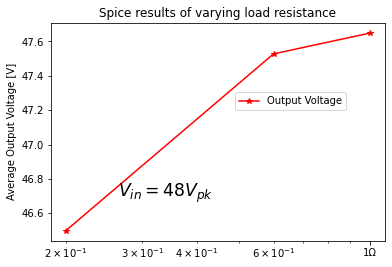

In [24]:

fix, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(rload, voavg ,marker='*', label='Output Voltage', color='red')
major_formatter= EngFormatter(unit='\u03A9', places=0, sep='')
ax.xaxis.set_major_formatter(major_formatter)    
#ax2 = ax.twinx()
#ax2.plot(rload ,cload, marker='^', label='load capacitance')
#major_formatter= EngFormatter(unit='F', places=1, sep='')
#ax2.yaxis.set_major_formatter(major_formatter)    
ax.legend(loc=(.55,.6))
#ax2.legend(loc=(.55,.5))
#ax2.set_yscale('log')
ax.set_ylabel('Average Output Voltage [V]')
#ax2.set_ylabel('Load Capacitance [F]')
ax.annotate(r'$V_{in} = 48V_{pk}$', (.2,.2), xycoords='axes fraction', fontsize='xx-large')
ax.set_title(r'Spice results of varying load resistance')
#ax.yaxis.set_major_formatter(EngFormatter(unit='03A9', places=1, sep=''))  

Text(0.5, 1.0, 'Spice results of varying load resistance')

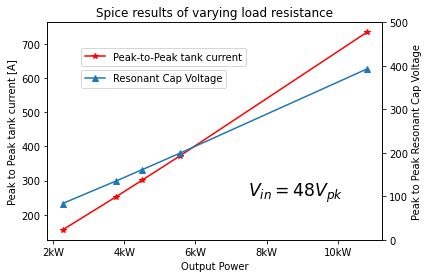

In [32]:
fix, ax = plt.subplots(1,1)
#ax.set_xscale('log')
ax.plot(pout,iinpkpk,marker='*', label='Peak-to-Peak tank current', color='red')
major_formatter= EngFormatter(unit='W', places=0, sep='')
ax.xaxis.set_major_formatter(major_formatter)    
ax2 = ax.twinx()
ax2.plot(pout ,vcrespkpk , marker='^', label='Resonant Cap Voltage')
#major_formatter= EngFormatter(unit='F', places=1, sep='')
#ax2.yaxis.set_major_formatter(major_formatter)    
ax.legend(loc=(.1,.8))
ax2.legend(loc=(.1,.7))
ax2.set_ylim(0,500)
ax.set_ylabel('Peak to Peak tank current [A]')
ax.set_xlabel('Output Power')
ax2.set_ylabel('Peak to Peak Resonant Cap Voltage')
ax.annotate(r'$V_{in} = 48V_{pk}$', (.6,.2), xycoords='axes fraction', fontsize='xx-large')
ax.set_title(r'Spice results of varying load resistance')
#ax.yaxis.set_major_formatter(EngFormatter(unit='03A9', places=1, sep='')) 